# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os 

from PIL import Image
from torchvision import datasets, transforms, models
from torch import nn
from collections import OrderedDict
from torch import optim


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_transforms = {
    "train": transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(), 
                                 normalize]),
     "test": transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 normalize]),
     "validation": transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       normalize])
}

# DONE: Load the datasets with ImageFolder
image_datasets = {
    "train": datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    "test": datasets.ImageFolder(test_dir, transform=data_transforms["test"]),
    "validation":  datasets.ImageFolder(valid_dir, transform=data_transforms["validation"])
}

# DONE: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=64, shuffle=True),
    "test": torch.utils.data.DataLoader(image_datasets["test"], batch_size=32),
    "validation":  torch.utils.data.DataLoader(image_datasets["validation"], batch_size=32)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# helpers methods 
def validate(model, testloader, criterion, device=None):
    """Function to validate(test) a model

    Args:
        model (:nn.Module): The model use for validation
        testloader (:DataLoader): The training dataloader
        criterion : The loss function
        device (string): The device to use 
    Returns:
        (accuracy, test_loss) : the accuracy and the test loss of the test 
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    model.to(device)
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # output of the test batch
        output = model.forward(images)
        # calculate the test loss and increment the variable
        loss = criterion(output, labels)
        test_loss += loss.item() 
        # probabilites since log soft_max is used we need to calcultate the exp to get the probabilites
        ps = torch.exp(output)
        # get the higherst prob
        predicted_classes = ps.max(dim=1)[1]
        compare_results = predicted_classes == labels.data
        accuracy += compare_results.type(torch.FloatTensor).mean()
    return accuracy, test_loss
    

def train_network(model, train_dataloader, optimizer, criterion, epochs = 1, 
                  validatation_dataloader = None, device = None, print_every = 50):
    """Function to train a model

    Args:
        model (:nn.Module): The model to train
        train_dataloader (:DataLoader): The training dataloader
        validatation_dataloader (:DataLoader, optional): The validation dataloader 
        device (string): The device to use 
        optimizer : The optimiser 
        criterion : The loss function
        epochs (int, optional) : The number of epoch to run 
        print_every (int, optional) : The number of iteration before printing the status 
        
    """
    # if the device is not set, get the device
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    model.to(device)
    steps = 0
    running_loss = 0
    
    for e in range(epochs):
        # set the model in train mode to prevent the case if it has been set in eval mode
        start_time = time.time()
        model.train()
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            steps += 1
            # set the grad to zero before the forward
            optimizer.zero_grad()
            # get the output of the model
            output = model.forward(images)
            # calculate the loss
            loss = criterion(output, labels)
            # do the back propagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # check the validation accuracy and loss if the validation_dataloader is set 
                if(validatation_dataloader is not None) :
                    # set model in eval mode
                    model.eval()
                    #disable grad 
                    with torch.no_grad():
                        accuracy, validation_loss = validate(model, validatation_dataloader, criterion, device)

                    #print status
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.4f}.. ".format(running_loss/print_every),
                          "Validation test Loss: {:.4f}.. ".format(validation_loss/len(validatation_dataloader)),
                          "validation test Accuracy: {:.4f}".format(accuracy/len(validatation_dataloader)))

                    model.train()
                else:
                    #print status
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.4f}.. ".format(running_loss/print_every))
                running_loss = 0
        print("Epoch run time {}".format(time.time()-start_time))


In [6]:
# Model class 
# Make the hidden layers to be some parameters to be able to test multiple configurations 
class ClassifierNetwork(nn.Module):
    """Classifier model 
    
    Args:
        input_size (int): size of the input 
        output_size (int): size of the output
        hidden_layers (list of int): a list of the sizes of the hidden layers 
        drop_p (float, optional): the dropout of the layers in the  network 
    """

    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super().__init__()
        
        self.input = nn.Linear(input_size, hidden_layers[0])
        
        self.hidden_layers = nn.ModuleList([])
        layers_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(l1, l2) for l1, l2 in layers_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [7]:
# TODO: Build and train your network

## Build the network 
# get the vgg11 model with 11 layers it is simplier to train 
model = models.vgg11(pretrained=True)
# freeze all the parameters 
for param in model.parameters():
    param.requires_grad = False

# create the classifier network and assign it to the classifier layer of the vgg11 model 
# the classifier layer takes 25088 in input since we have 102 classes, the output should be 102 
# after testing multiple configurations 2000 in the "hidden layers" is the best 
# our layes  will be [(25088, 2000), (2000, 102)]
model.classifier = ClassifierNetwork(25088, 102, [2000], 0.5)


In [8]:
## Train the network

# get the available device               
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# criterion and loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Monitor the training time of the whole model 
start_time = time.time()

# train the network
train_network(model, dataloaders['train'], optimizer, criterion, 5, 
              dataloaders['validation'], device, print_every = 32)
print("Training time {}".format(time.time()-start_time)) 

Epoch: 1/5..  Training Loss: 3.6166..  Validation test Loss: 2.3282..  validation test Accuracy: 0.4951
Epoch: 1/5..  Training Loss: 2.1909..  Validation test Loss: 1.1637..  validation test Accuracy: 0.7481
Epoch: 1/5..  Training Loss: 1.4647..  Validation test Loss: 0.7849..  validation test Accuracy: 0.8040
Epoch run time 372.7203416824341
Epoch: 2/5..  Training Loss: 1.0488..  Validation test Loss: 0.6022..  validation test Accuracy: 0.8580
Epoch: 2/5..  Training Loss: 0.8789..  Validation test Loss: 0.4958..  validation test Accuracy: 0.8861
Epoch: 2/5..  Training Loss: 0.8159..  Validation test Loss: 0.4685..  validation test Accuracy: 0.8813
Epoch run time 211.81999254226685
Epoch: 3/5..  Training Loss: 0.7279..  Validation test Loss: 0.4381..  validation test Accuracy: 0.8849
Epoch: 3/5..  Training Loss: 0.6545..  Validation test Loss: 0.4069..  validation test Accuracy: 0.9077
Epoch: 3/5..  Training Loss: 0.6535..  Validation test Loss: 0.3619..  validation test Accuracy: 0.91

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# DONE: Do validation on the test set
model.eval()
#disable grad 
with torch.no_grad():
    accuracy, test_loss = validate(model, dataloaders["test"], criterion, device)

#print status
print("Test Loss: {:.4f}.. ".format(test_loss/len(dataloaders["test"])),
      "Test Accuracy: {:.4f}".format(accuracy/len(dataloaders["test"])))

Test Loss: 0.3187..  Test Accuracy: 0.9178


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# DONE: Save the checkpoint 

def save_model(model, train_dataset, optimizer, filepath): 
    """ Save the model to a checkpoint file  
    
    Args:
        file_path (string): The path of the saved file
    """
    
    # Get the model layers
    model_hidden_layers = [x.out_features for x in model.classifier.hidden_layers ]
    if model_hidden_layers == []:
        model_hidden_layers.append(model.classifier.input.out_features)
    
    checkpoint_data = {
        "model_state_dict": model.state_dict(),
        "model_classifier_hidden_layers": model_hidden_layers,
        "model_classifier_dropout": model.classifier.dropout.p,
        "model_class_to_idx": train_dataset.class_to_idx,
        "optimizer_state_dict": optimizer.state_dict,
        "optimizer_learning_rate": optimizer.param_groups[0]["lr"]
    }

    torch.save(checkpoint_data, filepath)

save_model(model, image_datasets["train"], optimizer, "checkpoint.pth")

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def build_model(file_path, device):
    """ Rebuild the model from the checkpoint save file 
    
    Args:
        file_path (string): The path of the saved file
        device (string): The device to load the data on
    Returns:
        (model, optimizer): The rebuilded model and optimizer from the parameters 
    """
    checkpoint_data = torch.load(file_path, map_location=torch.device(device))
    
    # create and load the state to the new model 
    loaded_model = models.vgg11(pretrained=True)
    loaded_model.classifier = ClassifierNetwork(25088, 102, checkpoint_data["model_classifier_hidden_layers"], 
                                         checkpoint_data["model_classifier_dropout"])
    
    
    loaded_model.load_state_dict(checkpoint_data["model_state_dict"])
    loaded_model.class_to_idx = checkpoint_data["model_class_to_idx"]
    
    # create and load the state to the new optimizer 
    loaded_optimizer = optim.Adam(loaded_model.classifier.parameters(), 
                                  lr=checkpoint_data["optimizer_learning_rate"])
    loaded_optimizer.state_dict = checkpoint_data["optimizer_state_dict"]
    
    return loaded_model, loaded_optimizer


## LOAD the model

# get the available device               
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# criterion and loss
criterion = nn.NLLLoss()
loaded_model, loaded_optimizer = build_model("checkpoint.pth", device)


# test the loaded model
loaded_model.eval()
#disable grad 
with torch.no_grad():
    accuracy, test_loss = validate(loaded_model, dataloaders["test"], criterion, device)

#print status
print("Test Loss: {:.4f}.. ".format(test_loss/len(dataloaders["test"])),
      "Test Accuracy: {:.4f}".format(accuracy/len(dataloaders["test"])))

Test Loss: 0.3187..  Test Accuracy: 0.9178


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # DONE: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    
    # pytorch transforms can be used on and PIL.Image object 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    normalize])
    im = transform(im)
    return im


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    if title is not None:
        ax.set_title(title)
    
    return ax

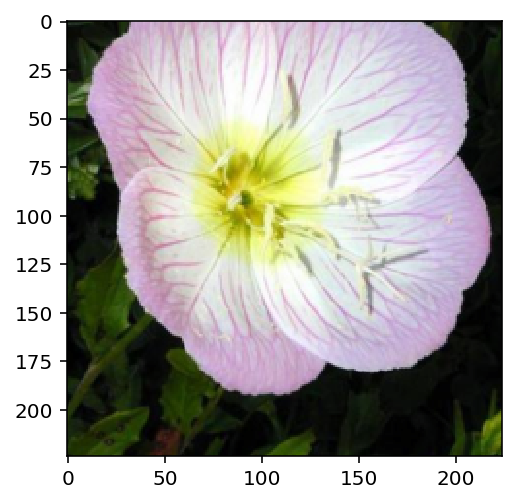

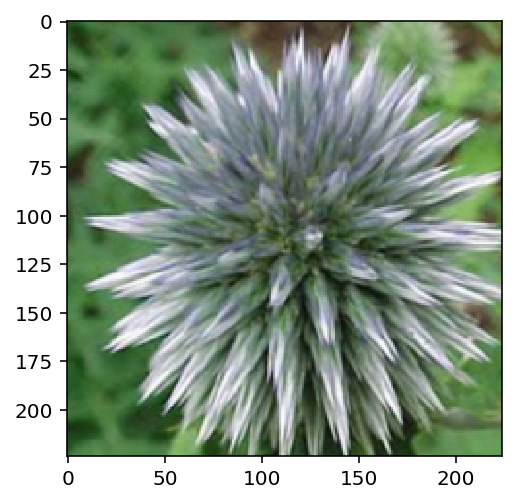

In [14]:
# test the transform array 
image = process_image("./flowers/test/1/image_06743.jpg")
imshow(image)

image = process_image("./flowers/test/10/image_07117.jpg")
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [15]:
def predict(image_path, model_checkpoint, device = None, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model, optimizer = build_model(model_checkpoint, device)
    
    model.to(device)
    image = process_image(image_path)
    image = image.to(device)
    # unsequeeze the image to match the input of the network 
    image.unsqueeze_(0)
    
    # put model in eval mode 
    model.eval()
    #disable grad 
    with torch.no_grad():
        # output of the test batch
        output = model.forward(image)
        # probabilites since log soft_max is used we need to calcultate the exp to get the probabilites
        ps = torch.exp(output)
    # copy the data to the cpu befor converting to array
    ps = ps.cpu()
    # get the topk probabilities 
    ps = ps.topk(topk)
    probs = ps.values.numpy()[0]
    indices = ps.indices.numpy()[0]
    
    #get the classes of the probs  
    idx_to_class = {y: x for x, y in model.class_to_idx.items()} 
    classes = [idx_to_class[x] for x in indices]
    
    return probs, classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
probs, classes = predict("./flowers/test/1/image_06743.jpg", "checkpoint.pth", device)

print(probs)
print(classes)

[9.9565971e-01 2.3019111e-03 5.3276774e-04 4.9958384e-04 1.3827492e-04]
['1', '86', '89', '18', '83']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

# TODO: Display an image along with the top 5 classes

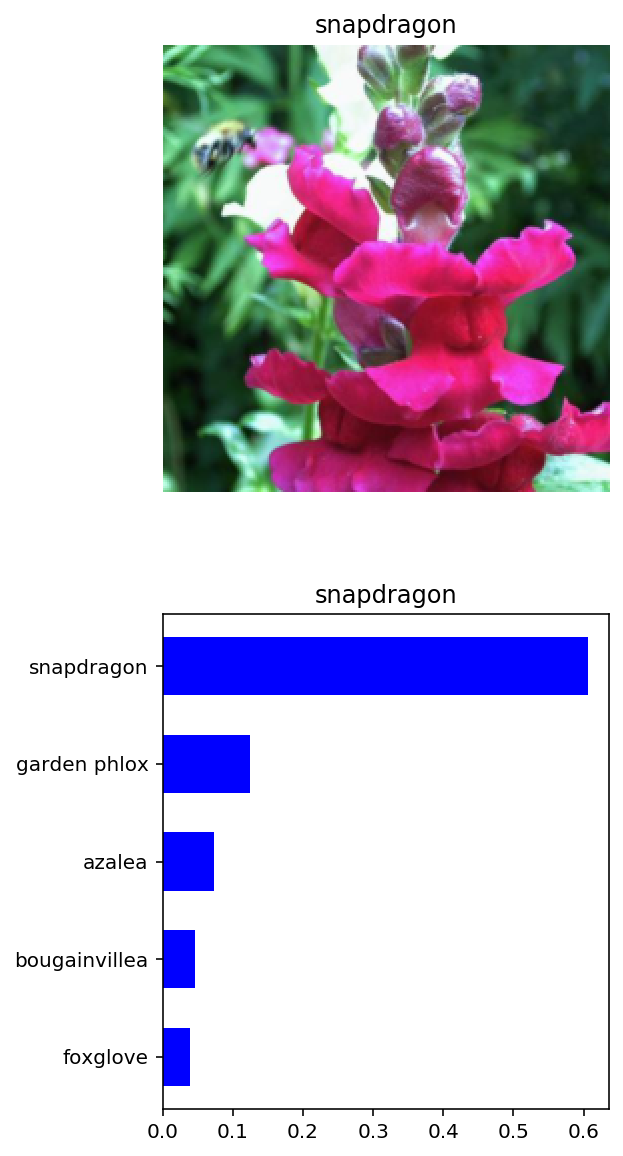

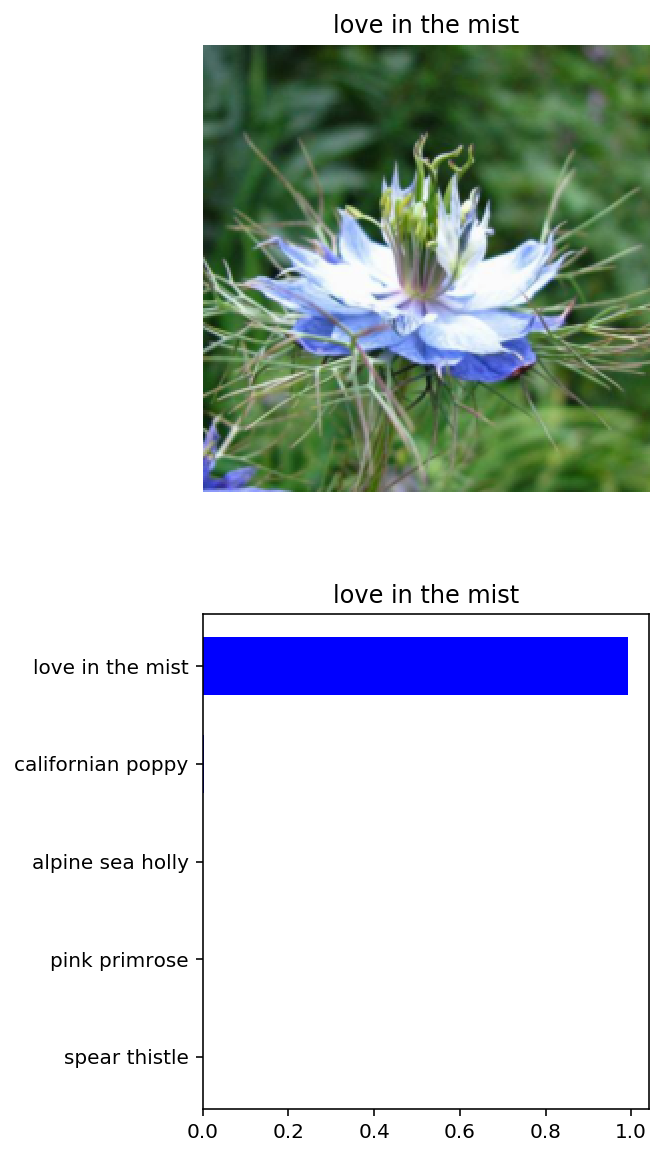

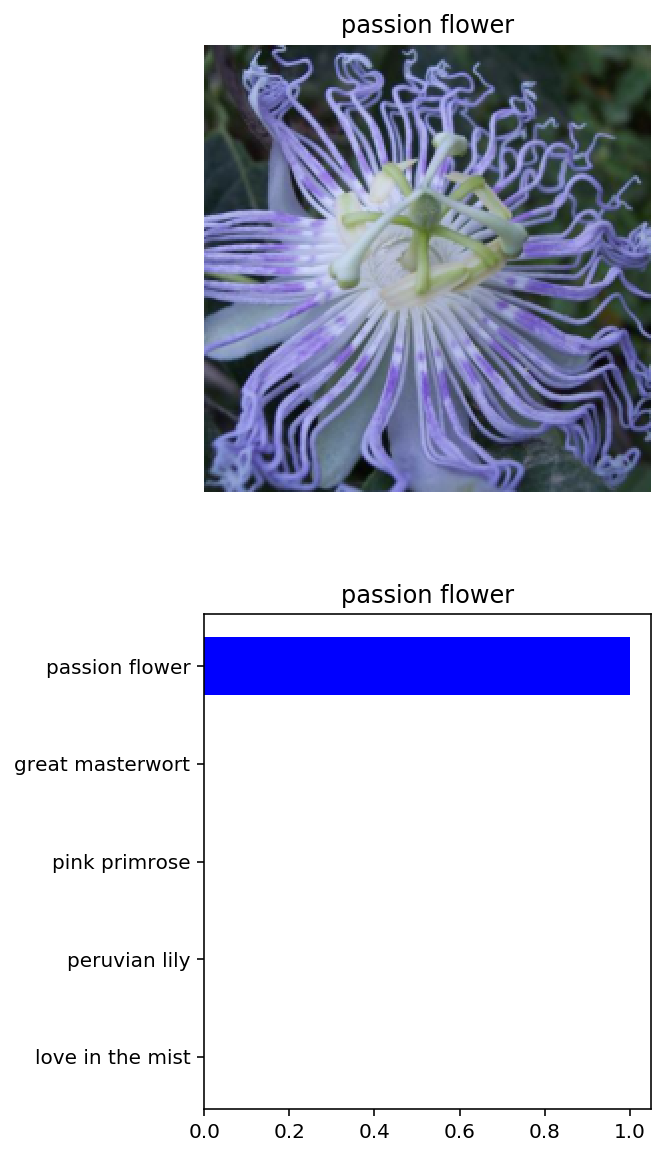

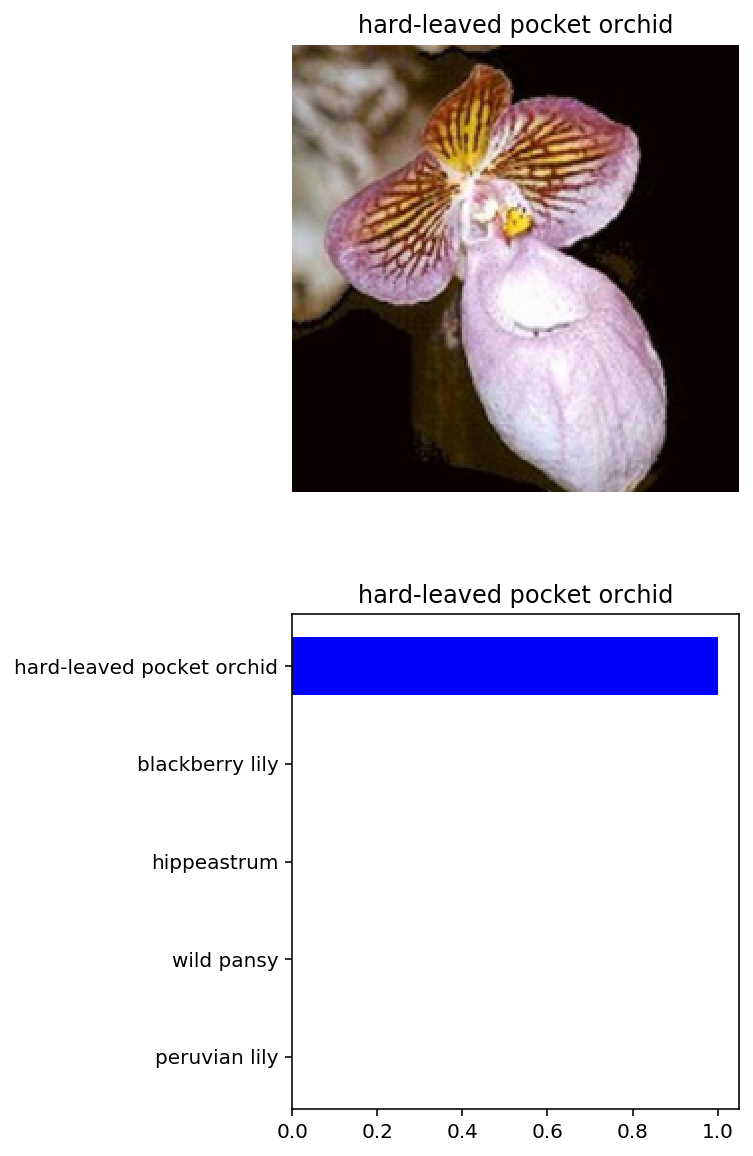

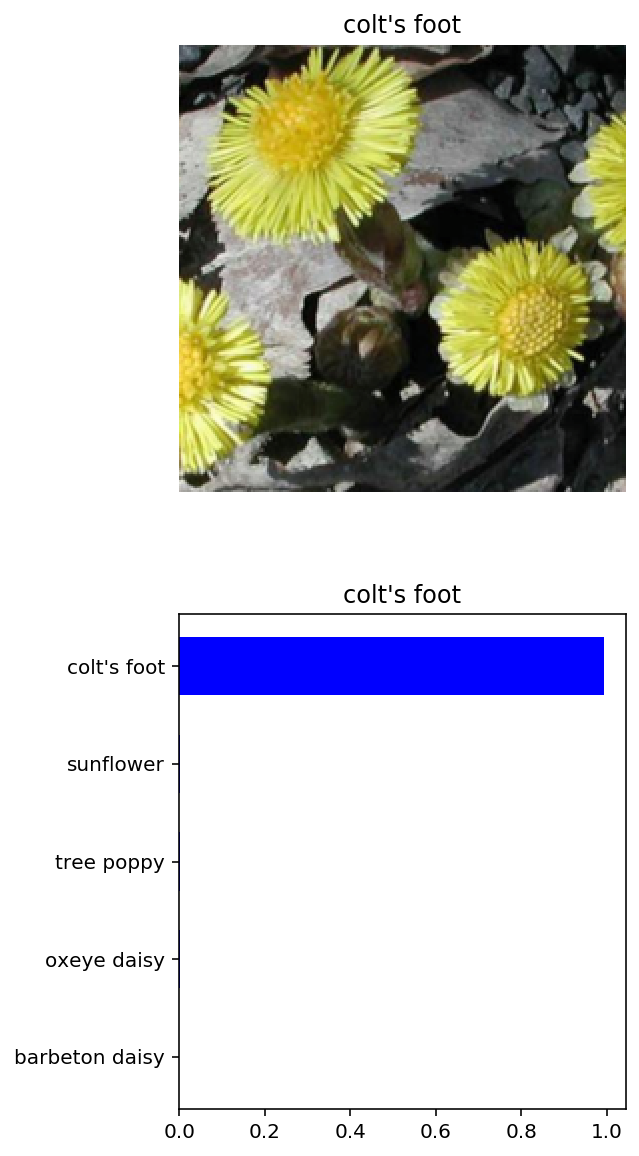

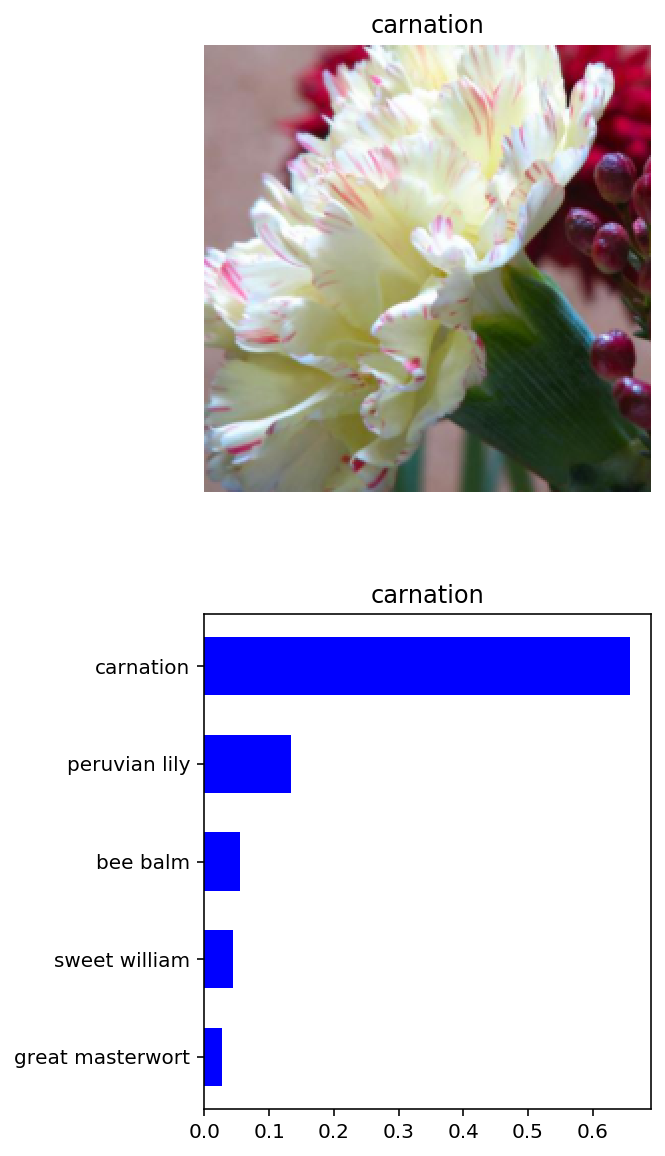

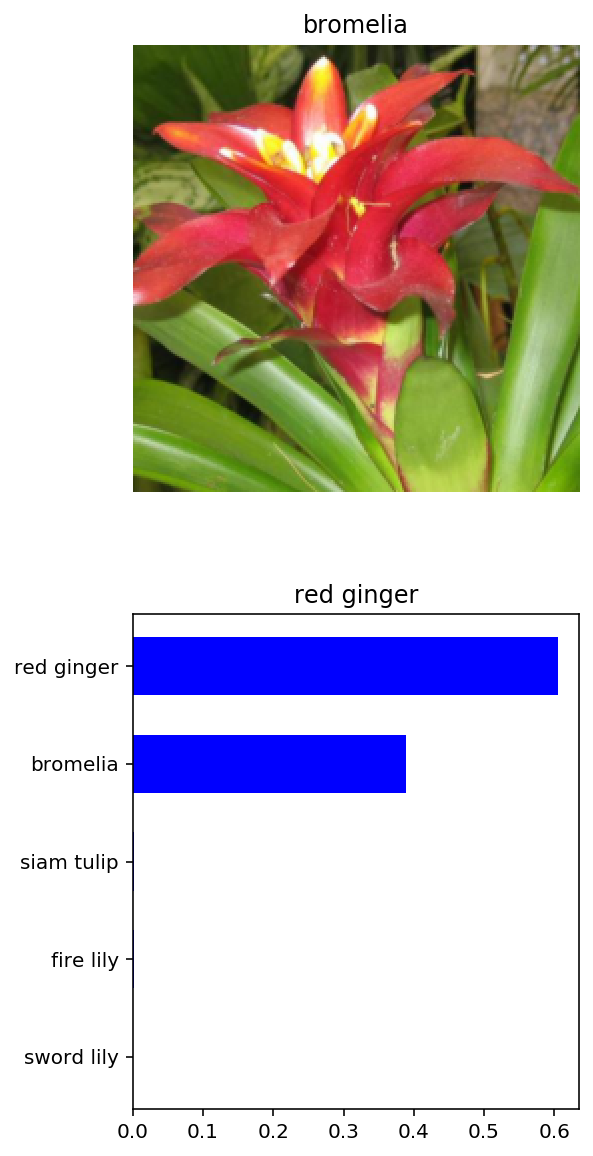

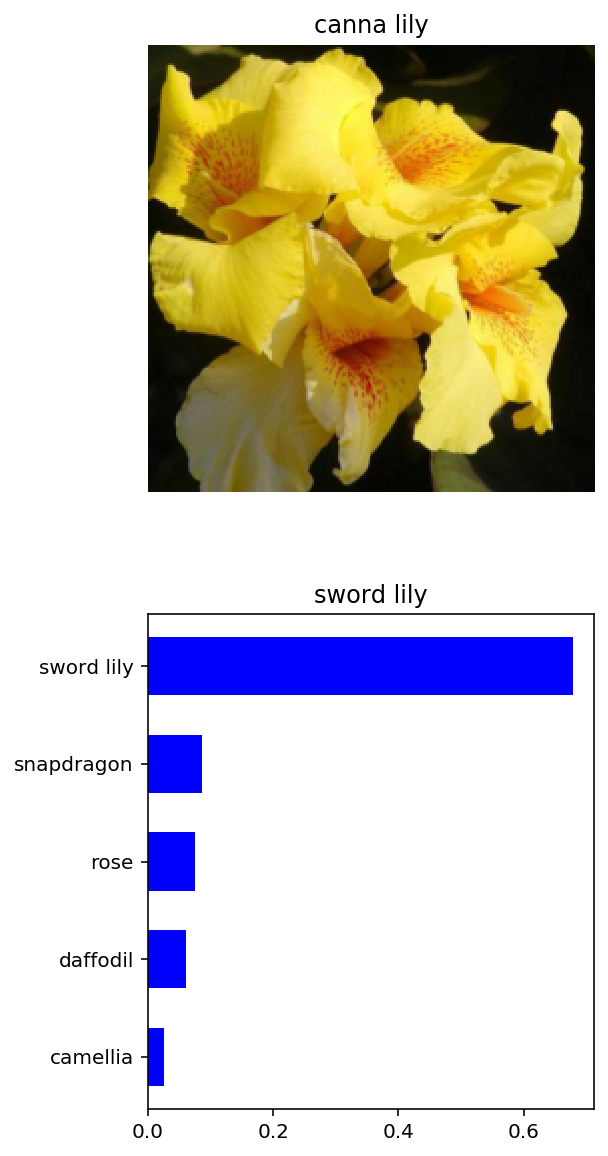

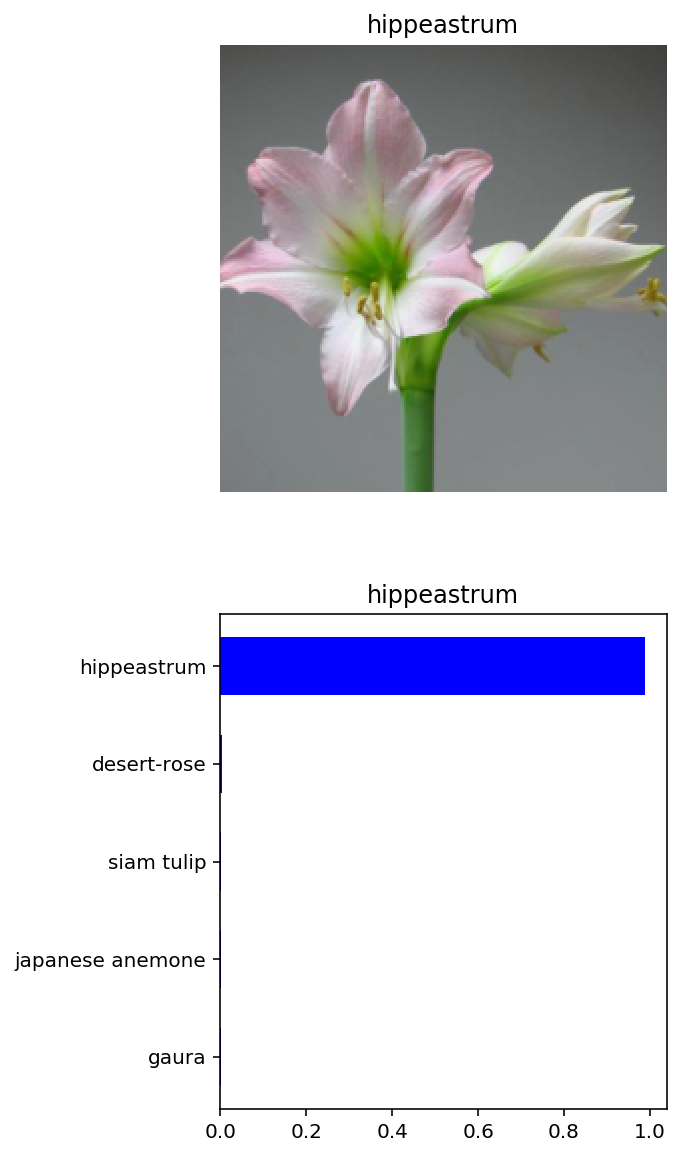

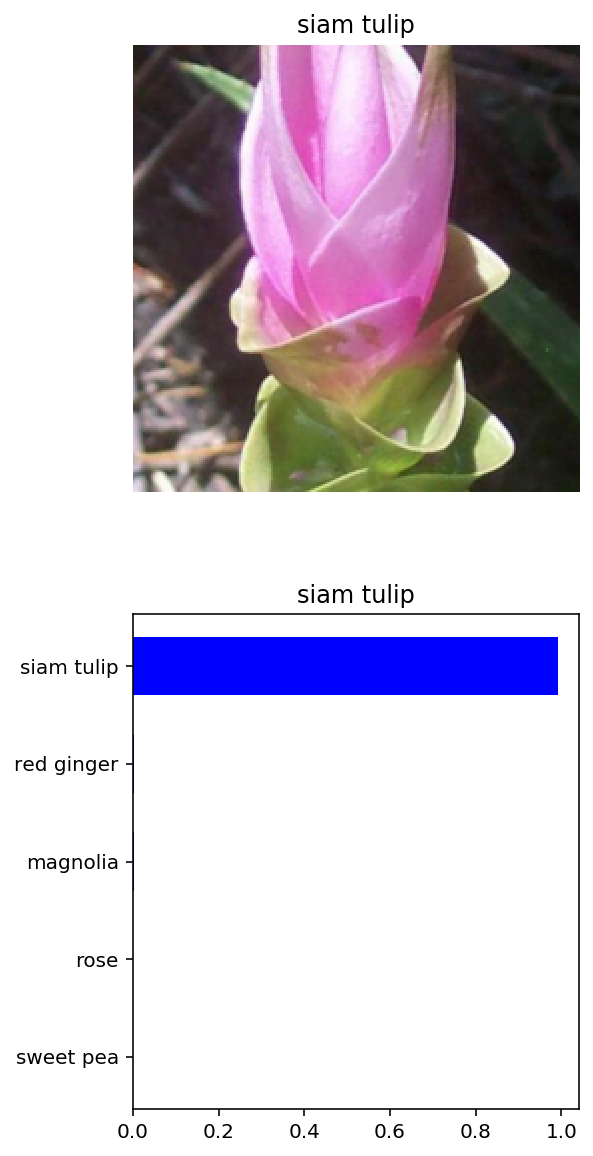

In [16]:
def check_image(image_path, image_label, model_checkpoint, class_name_map, device):
    ''' Check the images 
        get the image predictions and plot the image and the prediction
        
    Args:
        image_path (string): The path of the image to check
        image_label (string): The image label not the predicted one 
        model_checkpoint (string): The file of the checkpoint of the model
        class_name_map (:dict of string): The mapping of the class and the label 
        device (string): The device to use
    '''
    # process the image
    image = process_image(image_path)
    # get the predictions
    probs, classes = predict(image_path, model_checkpoint, device)
    # plot 
    fig, axs = plt.subplots(2,figsize = (4,10))
    axs[0] = imshow(image, axs[0], image_label)
    axs[0].axis('off')
    
    names = [class_name_map[x] for x in classes]
    axs[1].barh(names, probs, color='blue', height = 0.6)
    axs[1].set_title(names[probs.argmax()])
    axs[1].invert_yaxis()


def get_random_images(images_dir, class_name_map, number = 4):
    ''' Get some random images from a folder
    Args:
        images_dir (string): The path of the images folder 
        number (int): The number of the images to return 
    Returns: 
        images (list of tupes (image, label)): returns a list of tuples with the image path and the label 
    '''
    images_paths = []
    for path, dirs, files in os.walk(images_dir):
        for f in files:
            images_paths.append(os.path.normpath(path+'/'+f))

    images_map = np.array([ (x, class_name_map[x.split(os.path.sep)[-2]]) for x in images_paths ])

    idx = np.random.choice(len(images_map), number)

    return images_map[idx]

# test the sanity with a random number of images from the test dir 
for image_path, image_label in get_random_images(test_dir, cat_to_name, 10):
    model_checkpoint = "checkpoint.pth"
    image = check_image(image_path, image_label, model_checkpoint, cat_to_name, device)
    

# *Sources*

* https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5
* https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html
* https://github.com/S-Tabor/udacity-image-classifier-project/blob/master/Image%20Classifier%20Project.ipynb